## Installation required in Colab

In [56]:
# ! git clone https://github.com/shaoanlu/diffusion_policy_quadrotor.git

In [57]:
# %cd diffusion_policy_quadrotor
# %ls

In [58]:
# %%capture
# !pip3 install torch==1.13.1 torchvision==0.14.1 diffusers==0.18.2 jax==0.4.23 jaxlib==0.4.23

## Description

This notebook demonstrate using a diffusion policy controller to drive a quadrotor moving from (0, 0) to (5, 5) with random circle obstacles presented.

In [59]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [60]:
import numpy as np
import os
import torch
import yaml
import collections
from tqdm.auto import tqdm
import gdown

In [61]:
from utils.normalizers import LinearNormalizer
from core.controllers.quadrotor_diffusion_policy import QuadrotorDiffusionPolicy, build_networks_from_config, build_noise_scheduler_from_config
from core.controllers.quadrotor_clf_cbf_qp import QuadrotorCLFCBFController
from core.env.planar_quadrotor import PlanarQuadrotorEnv
from utils.visualization import visualize_quadrotor_simulation_result

## Load the config file

In [62]:
with open("config/config_ee2d.yaml", "r") as file:
    config = yaml.safe_load(file)

# Whether to use a finetuned model trained following tricks mentioned in
# [Fine-Tuning Image-Conditional Diffusion Models is Easier than You Think](https://arxiv.org/abs/2409.11355)
use_single_step_inference = config.get("controller").get("common").get("use_single_step_inference", False)

## Instantiate the controller

In [63]:
torch.cuda.is_available() # TODO

True

In [64]:
# clf_cbf_controller = QuadrotorCLFCBFController(config=config)

controller = QuadrotorDiffusionPolicy(
    model=build_networks_from_config(config),
    noise_scheduler=build_noise_scheduler_from_config(config),
    normalizer=LinearNormalizer(),
    clf_cbf_controller=None,  # set as clf_cbf_controller to enable CLF-CBF traj refinement
    config=config,
    device="cuda" if torch.cuda.is_available() else "cpu",
)

## Download and load pretrained weights

In [65]:
ckpts_path = "train/ckpt_final_100_epochs.ckpt"
controller.load_weights(ckpts_path)

## Run simulation

In [73]:
def inference(state, centers, rads, max_steps=20, take_only_first_action=False):
    # data preparation
    print(f"Start state: {state}")
    states = [state]  # `states` is a list containing the states over time
    obs_encode = np.hstack([centers, rads]).flatten()
    obs = {
        "state": collections.deque([state] * controller.obs_horizon, maxlen=controller.obs_horizon),
        "obs_encode": [obs_encode],
    }

    # termination params
    done = False
    step_idx = 0
    with tqdm(total=max_steps, desc="Eval") as pbar:
        while not done:
            # controller inference
            action = controller.predict_action(obs) # TODO: out of [[-1,1],[-1,1],] bounds

            # execute action_horizon steps without replanning
            print(f"Step {step_idx}")
            print(f"state: {state}, action0: {action[0]}")
            print(f"obs ", obs["state"])
            for i in range(action.shape[0]):
                state = action[i]
                # save observations and controls
                obs["state"].append(state.copy())
                states.append(state.copy())

                # update progress bar
                step_idx += 1
                pbar.update(1)
                if step_idx > max_steps:
                    done = True
                if take_only_first_action or done:
                    break
    return states

In [74]:
from dataset.escape_from_u_generator import generate_u_obstacles
np.random.seed(1223)

# Env parameters
max_steps = 20

# get first observation
centers, rads = generate_u_obstacles()
start_x = np.random.uniform(centers[0][0] + rads[0][0], centers[2][0] - rads[2][0])
start_y = np.random.uniform(centers[1][1] + rads[1][1], 0.7)
state = np.array([start_x, start_y])  # [y, y_dot, z, z_dot, phi, phi_dot]

# run inference
states = inference(state, centers, rads, max_steps=max_steps, take_only_first_action=True)

Start state: [0.22516923 0.66587321]


Eval:   5%|▌         | 1/20 [00:00<00:10,  1.87it/s]

Step 0
state: [0.22516923 0.66587321], action0: [0.18285993 0.44784874]
obs  deque([array([0.22516923, 0.66587321]), array([0.22516923, 0.66587321]), array([0.22516923, 0.66587321]), array([0.22516923, 0.66587321])], maxlen=4)


Eval:  10%|█         | 2/20 [00:01<00:09,  1.96it/s]

Step 1
state: [0.18285993 0.44784874], action0: [0.2996735  0.41499615]
obs  deque([array([0.22516923, 0.66587321]), array([0.22516923, 0.66587321]), array([0.22516923, 0.66587321]), array([0.18285993, 0.44784874])], maxlen=4)


Eval:  15%|█▌        | 3/20 [00:01<00:08,  1.99it/s]

Step 2
state: [0.2996735  0.41499615], action0: [0.37377846 0.544815  ]
obs  deque([array([0.22516923, 0.66587321]), array([0.22516923, 0.66587321]), array([0.18285993, 0.44784874]), array([0.2996735 , 0.41499615])], maxlen=4)


Eval:  20%|██        | 4/20 [00:02<00:07,  2.00it/s]

Step 3
state: [0.37377846 0.544815  ], action0: [0.46878293 0.40620187]
obs  deque([array([0.22516923, 0.66587321]), array([0.18285993, 0.44784874]), array([0.2996735 , 0.41499615]), array([0.37377846, 0.544815  ])], maxlen=4)


Eval:  25%|██▌       | 5/20 [00:02<00:07,  2.01it/s]

Step 4
state: [0.46878293 0.40620187], action0: [0.54370463 0.37964126]
obs  deque([array([0.18285993, 0.44784874]), array([0.2996735 , 0.41499615]), array([0.37377846, 0.544815  ]), array([0.46878293, 0.40620187])], maxlen=4)


Eval:  30%|███       | 6/20 [00:03<00:06,  2.01it/s]

Step 5
state: [0.54370463 0.37964126], action0: [0.6297797  0.50889421]
obs  deque([array([0.2996735 , 0.41499615]), array([0.37377846, 0.544815  ]), array([0.46878293, 0.40620187]), array([0.54370463, 0.37964126])], maxlen=4)


Eval:  35%|███▌      | 7/20 [00:03<00:06,  2.02it/s]

Step 6
state: [0.6297797  0.50889421], action0: [0.58886296 0.40476859]
obs  deque([array([0.37377846, 0.544815  ]), array([0.46878293, 0.40620187]), array([0.54370463, 0.37964126]), array([0.6297797 , 0.50889421])], maxlen=4)


Eval:  40%|████      | 8/20 [00:03<00:05,  2.02it/s]

Step 7
state: [0.58886296 0.40476859], action0: [0.67025    0.41769227]
obs  deque([array([0.46878293, 0.40620187]), array([0.54370463, 0.37964126]), array([0.6297797 , 0.50889421]), array([0.58886296, 0.40476859])], maxlen=4)


Eval:  45%|████▌     | 9/20 [00:04<00:05,  2.02it/s]

Step 8
state: [0.67025    0.41769227], action0: [0.71729732 0.37904152]
obs  deque([array([0.54370463, 0.37964126]), array([0.6297797 , 0.50889421]), array([0.58886296, 0.40476859]), array([0.67025   , 0.41769227])], maxlen=4)


Eval:  50%|█████     | 10/20 [00:04<00:04,  2.02it/s]

Step 9
state: [0.71729732 0.37904152], action0: [0.78911352 0.34795538]
obs  deque([array([0.6297797 , 0.50889421]), array([0.58886296, 0.40476859]), array([0.67025   , 0.41769227]), array([0.71729732, 0.37904152])], maxlen=4)


Eval:  55%|█████▌    | 11/20 [00:05<00:04,  2.02it/s]

Step 10
state: [0.78911352 0.34795538], action0: [0.769494   0.40872192]
obs  deque([array([0.58886296, 0.40476859]), array([0.67025   , 0.41769227]), array([0.71729732, 0.37904152]), array([0.78911352, 0.34795538])], maxlen=4)


Eval:  60%|██████    | 12/20 [00:05<00:03,  2.02it/s]

Step 11
state: [0.769494   0.40872192], action0: [0.79024446 0.40940756]
obs  deque([array([0.67025   , 0.41769227]), array([0.71729732, 0.37904152]), array([0.78911352, 0.34795538]), array([0.769494  , 0.40872192])], maxlen=4)


Eval:  65%|██████▌   | 13/20 [00:06<00:03,  2.02it/s]

Step 12
state: [0.79024446 0.40940756], action0: [0.79948723 0.34650898]
obs  deque([array([0.71729732, 0.37904152]), array([0.78911352, 0.34795538]), array([0.769494  , 0.40872192]), array([0.79024446, 0.40940756])], maxlen=4)


Eval:  70%|███████   | 14/20 [00:06<00:02,  2.02it/s]

Step 13
state: [0.79948723 0.34650898], action0: [0.81751245 0.45659393]
obs  deque([array([0.78911352, 0.34795538]), array([0.769494  , 0.40872192]), array([0.79024446, 0.40940756]), array([0.79948723, 0.34650898])], maxlen=4)


Eval:  75%|███████▌  | 15/20 [00:07<00:02,  2.02it/s]

Step 14
state: [0.81751245 0.45659393], action0: [0.83741766 0.52717805]
obs  deque([array([0.769494  , 0.40872192]), array([0.79024446, 0.40940756]), array([0.79948723, 0.34650898]), array([0.81751245, 0.45659393])], maxlen=4)


Eval:  80%|████████  | 16/20 [00:07<00:01,  2.02it/s]

Step 15
state: [0.83741766 0.52717805], action0: [0.87650061 0.52906591]
obs  deque([array([0.79024446, 0.40940756]), array([0.79948723, 0.34650898]), array([0.81751245, 0.45659393]), array([0.83741766, 0.52717805])], maxlen=4)


Eval:  85%|████████▌ | 17/20 [00:08<00:01,  2.02it/s]

Step 16
state: [0.87650061 0.52906591], action0: [0.91070247 0.5211221 ]
obs  deque([array([0.79948723, 0.34650898]), array([0.81751245, 0.45659393]), array([0.83741766, 0.52717805]), array([0.87650061, 0.52906591])], maxlen=4)


Eval:  90%|█████████ | 18/20 [00:08<00:00,  2.02it/s]

Step 17
state: [0.91070247 0.5211221 ], action0: [0.93335223 0.49204397]
obs  deque([array([0.81751245, 0.45659393]), array([0.83741766, 0.52717805]), array([0.87650061, 0.52906591]), array([0.91070247, 0.5211221 ])], maxlen=4)


Eval:  95%|█████████▌| 19/20 [00:09<00:00,  2.02it/s]

Step 18
state: [0.93335223 0.49204397], action0: [0.9632107  0.49433967]
obs  deque([array([0.83741766, 0.52717805]), array([0.87650061, 0.52906591]), array([0.91070247, 0.5211221 ]), array([0.93335223, 0.49204397])], maxlen=4)


Eval: 100%|██████████| 20/20 [00:09<00:00,  2.02it/s]

Step 19
state: [0.9632107  0.49433967], action0: [0.97466171 0.41873363]
obs  deque([array([0.87650061, 0.52906591]), array([0.91070247, 0.5211221 ]), array([0.93335223, 0.49204397]), array([0.9632107 , 0.49433967])], maxlen=4)


Eval: 21it [00:10,  2.01it/s]                        

Step 20
state: [0.97466171 0.41873363], action0: [0.96609861 0.35713038]
obs  deque([array([0.91070247, 0.5211221 ]), array([0.93335223, 0.49204397]), array([0.9632107 , 0.49433967]), array([0.97466171, 0.41873363])], maxlen=4)


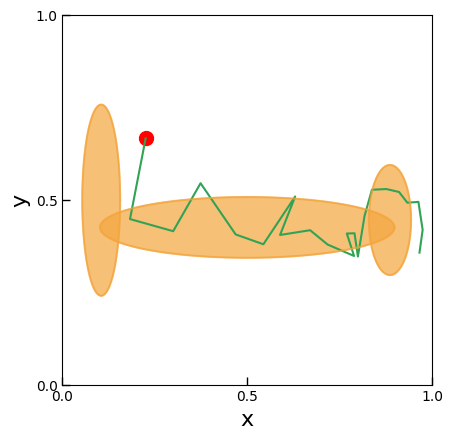

In [75]:
# Visualize the simulation result (single environment)
from dataset.escape_from_u_generator import plot
plot(states, None, centers, rads)

## Visualize Result in Batch

In [82]:
from dataset.escape_from_u_generator import plot_multiple
import joblib
import numpy as np
from matplotlib import pyplot as plt

Start state: [0.68390591 0.59808791]


Eval:   5%|▌         | 1/20 [00:00<00:11,  1.68it/s]

Step 0
state: [0.68390591 0.59808791], action0: [0.74429816 0.60296214]
obs  deque([array([0.68390591, 0.59808791]), array([0.68390591, 0.59808791]), array([0.68390591, 0.59808791]), array([0.68390591, 0.59808791])], maxlen=4)


Eval: 21it [00:01, 18.45it/s]                        


Step 13
state: [0.85888433 0.34708655], action0: [0.87217057 0.1912035 ]
obs  deque([array([0.9239338 , 0.55782282]), array([0.90526575, 0.50794947]), array([0.89093161, 0.42375788]), array([0.85888433, 0.34708655])], maxlen=4)
Start state: [0.42452022 0.61426271]


Eval:   5%|▌         | 1/20 [00:00<00:10,  1.83it/s]

Step 0
state: [0.42452022 0.61426271], action0: [0.40184778 0.59987718]
obs  deque([array([0.42452022, 0.61426271]), array([0.42452022, 0.61426271]), array([0.42452022, 0.61426271]), array([0.42452022, 0.61426271])], maxlen=4)


Eval: 21it [00:01, 19.19it/s]                        


Step 13
state: [0.23765194 0.43282431], action0: [0.22869739 0.42600054]
obs  deque([array([0.2923786 , 0.49315047]), array([0.26361799, 0.47327486]), array([0.24435744, 0.44798282]), array([0.23765194, 0.43282431])], maxlen=4)
Start state: [0.42400369 0.64052494]


Eval:   5%|▌         | 1/20 [00:00<00:10,  1.83it/s]

Step 0
state: [0.42400369 0.64052494], action0: [0.42637444 0.49046829]
obs  deque([array([0.42400369, 0.64052494]), array([0.42400369, 0.64052494]), array([0.42400369, 0.64052494]), array([0.42400369, 0.64052494])], maxlen=4)


Eval: 21it [00:01, 19.23it/s]                        


Step 13
state: [0.69496268 0.47854084], action0: [0.68484741 0.44842598]
obs  deque([array([0.69166547, 0.43188292]), array([0.71614063, 0.54092133]), array([0.68362826, 0.49804953]), array([0.69496268, 0.47854084])], maxlen=4)
Start state: [0.52035488 0.57535166]


Eval:   5%|▌         | 1/20 [00:00<00:10,  1.83it/s]

Step 0
state: [0.52035488 0.57535166], action0: [0.5106045  0.55854803]
obs  deque([array([0.52035488, 0.57535166]), array([0.52035488, 0.57535166]), array([0.52035488, 0.57535166]), array([0.52035488, 0.57535166])], maxlen=4)


Eval: 21it [00:01, 19.10it/s]                        


Step 13
state: [0.23162749 0.41230822], action0: [0.23130769 0.41858673]
obs  deque([array([0.24317035, 0.45132452]), array([0.23752642, 0.40752465]), array([0.23939174, 0.37944403]), array([0.23162749, 0.41230822])], maxlen=4)
Start state: [0.61018222 0.66141377]


Eval:   5%|▌         | 1/20 [00:00<00:10,  1.83it/s]

Step 0
state: [0.61018222 0.66141377], action0: [0.59944117 0.5673461 ]
obs  deque([array([0.61018222, 0.66141377]), array([0.61018222, 0.66141377]), array([0.61018222, 0.66141377]), array([0.61018222, 0.66141377])], maxlen=4)


Eval: 21it [00:01, 19.14it/s]                        


Step 13
state: [0.90305305 0.5466789 ], action0: [0.93322158 0.40373516]
obs  deque([array([0.79592276, 0.51157099]), array([0.81640059, 0.52266085]), array([0.82073122, 0.52057421]), array([0.90305305, 0.5466789 ])], maxlen=4)
Start state: [0.42481733 0.68970638]


Eval:   5%|▌         | 1/20 [00:00<00:10,  1.82it/s]

Step 0
state: [0.42481733 0.68970638], action0: [0.38292927 0.60755742]
obs  deque([array([0.42481733, 0.68970638]), array([0.42481733, 0.68970638]), array([0.42481733, 0.68970638]), array([0.42481733, 0.68970638])], maxlen=4)


Eval: 21it [00:01, 18.86it/s]                        


Step 13
state: [0.6451894  0.56642854], action0: [0.69652945 0.50596702]
obs  deque([array([0.49536651, 0.53301311]), array([0.52402306, 0.52062011]), array([0.60069555, 0.58293754]), array([0.6451894 , 0.56642854])], maxlen=4)
Start state: [0.53520641 0.60338661]


Eval:   5%|▌         | 1/20 [00:00<00:10,  1.79it/s]

Step 0
state: [0.53520641 0.60338661], action0: [0.57748854 0.49191758]
obs  deque([array([0.53520641, 0.60338661]), array([0.53520641, 0.60338661]), array([0.53520641, 0.60338661]), array([0.53520641, 0.60338661])], maxlen=4)


Eval: 21it [00:01, 18.57it/s]                        


Step 13
state: [0.16154698 0.4564791 ], action0: [0.16257867 0.39610186]
obs  deque([array([0.34170157, 0.41217273]), array([0.27284592, 0.43535721]), array([0.18687683, 0.53497332]), array([0.16154698, 0.4564791 ])], maxlen=4)
Start state: [0.62368274 0.67006459]


Eval:   5%|▌         | 1/20 [00:00<00:10,  1.80it/s]

Step 0
state: [0.62368274 0.67006459], action0: [0.66024643 0.60164779]
obs  deque([array([0.62368274, 0.67006459]), array([0.62368274, 0.67006459]), array([0.62368274, 0.67006459]), array([0.62368274, 0.67006459])], maxlen=4)


Eval: 21it [00:01, 18.94it/s]                        


Step 13
state: [0.13781261 0.51014513], action0: [0.08443412 0.54361117]
obs  deque([array([0.20198888, 0.44140381]), array([0.17653993, 0.42824668]), array([0.13487738, 0.52370191]), array([0.13781261, 0.51014513])], maxlen=4)
Start state: [0.63373544 0.67485725]


Eval:   5%|▌         | 1/20 [00:00<00:10,  1.82it/s]

Step 0
state: [0.63373544 0.67485725], action0: [0.67343545 0.65407544]
obs  deque([array([0.63373544, 0.67485725]), array([0.63373544, 0.67485725]), array([0.63373544, 0.67485725]), array([0.63373544, 0.67485725])], maxlen=4)


Eval: 21it [00:01, 19.14it/s]                        


Step 13
state: [0.95241272 0.47602987], action0: [0.95592403 0.4637714 ]
obs  deque([array([0.90989017, 0.59085804]), array([0.9504047 , 0.55477673]), array([0.95703   , 0.53569269]), array([0.95241272, 0.47602987])], maxlen=4)
Start state: [0.3900345  0.61828308]


Eval:   5%|▌         | 1/20 [00:00<00:10,  1.82it/s]

Step 0
state: [0.3900345  0.61828308], action0: [0.3979907  0.58541095]
obs  deque([array([0.3900345 , 0.61828308]), array([0.3900345 , 0.61828308]), array([0.3900345 , 0.61828308]), array([0.3900345 , 0.61828308])], maxlen=4)


Eval: 21it [00:01, 18.97it/s]                        


Step 13
state: [0.20209309 0.45758387], action0: [0.1798324  0.40692258]
obs  deque([array([0.28312111, 0.51087981]), array([0.25842863, 0.51510763]), array([0.2310479 , 0.49711797]), array([0.20209309, 0.45758387])], maxlen=4)
Start state: [0.74105203 0.68701149]


Eval:   5%|▌         | 1/20 [00:00<00:10,  1.76it/s]

Step 0
state: [0.74105203 0.68701149], action0: [0.69790947 0.6243664 ]
obs  deque([array([0.74105203, 0.68701149]), array([0.74105203, 0.68701149]), array([0.74105203, 0.68701149]), array([0.74105203, 0.68701149])], maxlen=4)


Eval: 21it [00:01, 18.48it/s]                        


Step 13
state: [0.96105194 0.52544206], action0: [0.97508407 0.4386642 ]
obs  deque([array([0.91993749, 0.59032208]), array([0.94294459, 0.50790387]), array([0.93717086, 0.51373875]), array([0.96105194, 0.52544206])], maxlen=4)
Start state: [0.80572163 0.62934812]


Eval:   5%|▌         | 1/20 [00:00<00:10,  1.78it/s]

Step 0
state: [0.80572163 0.62934812], action0: [0.81524312 0.57231247]
obs  deque([array([0.80572163, 0.62934812]), array([0.80572163, 0.62934812]), array([0.80572163, 0.62934812]), array([0.80572163, 0.62934812])], maxlen=4)


Eval: 21it [00:01, 18.58it/s]                        


Step 13
state: [0.72430551 0.09740329], action0: [0.74504447 0.11244181]
obs  deque([array([0.74360025, 0.23905152]), array([0.71554267, 0.18052053]), array([0.70753729, 0.10796142]), array([0.72430551, 0.09740329])], maxlen=4)
Start state: [0.37607386 0.58168911]


Eval:   5%|▌         | 1/20 [00:00<00:10,  1.82it/s]

Step 0
state: [0.37607386 0.58168911], action0: [0.39160001 0.52079171]
obs  deque([array([0.37607386, 0.58168911]), array([0.37607386, 0.58168911]), array([0.37607386, 0.58168911]), array([0.37607386, 0.58168911])], maxlen=4)


Eval: 21it [00:01, 18.97it/s]                        


Step 13
state: [0.2868183  0.39810753], action0: [0.27763212 0.37541321]
obs  deque([array([0.30284512, 0.36226901]), array([0.3021518 , 0.33700156]), array([0.30991274, 0.34776309]), array([0.2868183 , 0.39810753])], maxlen=4)
Start state: [0.75642716 0.60672726]


Eval:   5%|▌         | 1/20 [00:00<00:10,  1.82it/s]

Step 0
state: [0.75642716 0.60672726], action0: [0.77393019 0.59923697]
obs  deque([array([0.75642716, 0.60672726]), array([0.75642716, 0.60672726]), array([0.75642716, 0.60672726]), array([0.75642716, 0.60672726])], maxlen=4)


Eval: 21it [00:01, 19.02it/s]                        


Step 13
state: [0.78020215 0.35311818], action0: [0.76984227 0.31601548]
obs  deque([array([0.78252566, 0.43471876]), array([0.78074431, 0.41726422]), array([0.78310716, 0.38811612]), array([0.78020215, 0.35311818])], maxlen=4)
Start state: [0.29656125 0.69608096]


Eval:   5%|▌         | 1/20 [00:00<00:10,  1.76it/s]

Step 0
state: [0.29656125 0.69608096], action0: [0.30378962 0.62141109]
obs  deque([array([0.29656125, 0.69608096]), array([0.29656125, 0.69608096]), array([0.29656125, 0.69608096]), array([0.29656125, 0.69608096])], maxlen=4)


Eval: 21it [00:01, 18.33it/s]                        


Step 13
state: [0.10190007 0.45150313], action0: [0.08347237 0.47492656]
obs  deque([array([0.1340791 , 0.55900878]), array([0.11842877, 0.54438305]), array([0.1110158 , 0.47733355]), array([0.10190007, 0.45150313])], maxlen=4)
Start state: [0.6633755  0.58198847]


Eval:   5%|▌         | 1/20 [00:00<00:10,  1.74it/s]

Step 0
state: [0.6633755  0.58198847], action0: [0.68796611 0.55242598]
obs  deque([array([0.6633755 , 0.58198847]), array([0.6633755 , 0.58198847]), array([0.6633755 , 0.58198847]), array([0.6633755 , 0.58198847])], maxlen=4)


Eval: 21it [00:01, 18.23it/s]                        


Step 13
state: [0.92937016 0.36718896], action0: [0.97240496 0.26805615]
obs  deque([array([0.94401109, 0.52420324]), array([0.92822647, 0.56254816]), array([0.92907333, 0.46232411]), array([0.92937016, 0.36718896])], maxlen=4)
Start state: [0.48929155 0.50969301]


Eval:   5%|▌         | 1/20 [00:00<00:10,  1.74it/s]

Step 0
state: [0.48929155 0.50969301], action0: [0.45586845 0.4875297 ]
obs  deque([array([0.48929155, 0.50969301]), array([0.48929155, 0.50969301]), array([0.48929155, 0.50969301]), array([0.48929155, 0.50969301])], maxlen=4)


Eval: 21it [00:01, 18.27it/s]                        


Step 13
state: [0.28576043 0.44134554], action0: [0.28970158 0.40059769]
obs  deque([array([0.32964838, 0.45155156]), array([0.32843533, 0.46928048]), array([0.3058359 , 0.46383125]), array([0.28576043, 0.44134554])], maxlen=4)
Start state: [0.35800231 0.6282899 ]


Eval:   5%|▌         | 1/20 [00:00<00:10,  1.75it/s]

Step 0
state: [0.35800231 0.6282899 ], action0: [0.37270057 0.62048787]
obs  deque([array([0.35800231, 0.6282899 ]), array([0.35800231, 0.6282899 ]), array([0.35800231, 0.6282899 ]), array([0.35800231, 0.6282899 ])], maxlen=4)


Eval: 21it [00:01, 18.21it/s]                        


Step 13
state: [0.64822423 0.48040658], action0: [0.66192323 0.45169976]
obs  deque([array([0.56855947, 0.47326639]), array([0.6077112 , 0.48427296]), array([0.62934881, 0.49877638]), array([0.64822423, 0.48040658])], maxlen=4)
Start state: [0.65289016 0.64966455]


Eval:   5%|▌         | 1/20 [00:00<00:10,  1.74it/s]

Step 0
state: [0.65289016 0.64966455], action0: [0.63828015 0.56078213]
obs  deque([array([0.65289016, 0.64966455]), array([0.65289016, 0.64966455]), array([0.65289016, 0.64966455]), array([0.65289016, 0.64966455])], maxlen=4)


Eval: 21it [00:01, 18.24it/s]                        


Step 13
state: [0.69737601 0.44920218], action0: [0.72523224 0.46750426]
obs  deque([array([0.66742975, 0.46538508]), array([0.65237731, 0.4665744 ]), array([0.67391348, 0.44058672]), array([0.69737601, 0.44920218])], maxlen=4)
Start state: [0.50364093 0.67215953]


Eval:   5%|▌         | 1/20 [00:00<00:10,  1.73it/s]

Step 0
state: [0.50364093 0.67215953], action0: [0.45602664 0.58617806]
obs  deque([array([0.50364093, 0.67215953]), array([0.50364093, 0.67215953]), array([0.50364093, 0.67215953]), array([0.50364093, 0.67215953])], maxlen=4)


Eval: 21it [00:01, 18.19it/s]                        

Step 13
state: [0.0427033  0.65180296], action0: [0.07729605 0.55637461]
obs  deque([array([0.15774369, 0.69001192]), array([0.08921963, 0.65588224]), array([0.04207861, 0.65522677]), array([0.0427033 , 0.65180296])], maxlen=4)
Plotting environment 0
Plotting environment 1
Plotting environment 2
Plotting environment 3
Plotting environment 4
Plotting environment 5


Plotting environment 6
Plotting environment 7
Plotting environment 8
Plotting environment 9
Plotting environment 10
Plotting environment 11
Plotting environment 12
Plotting environment 13
Plotting environment 14
Plotting environment 15
Plotting environment 16
Plotting environment 17
Plotting environment 18
Plotting environment 19


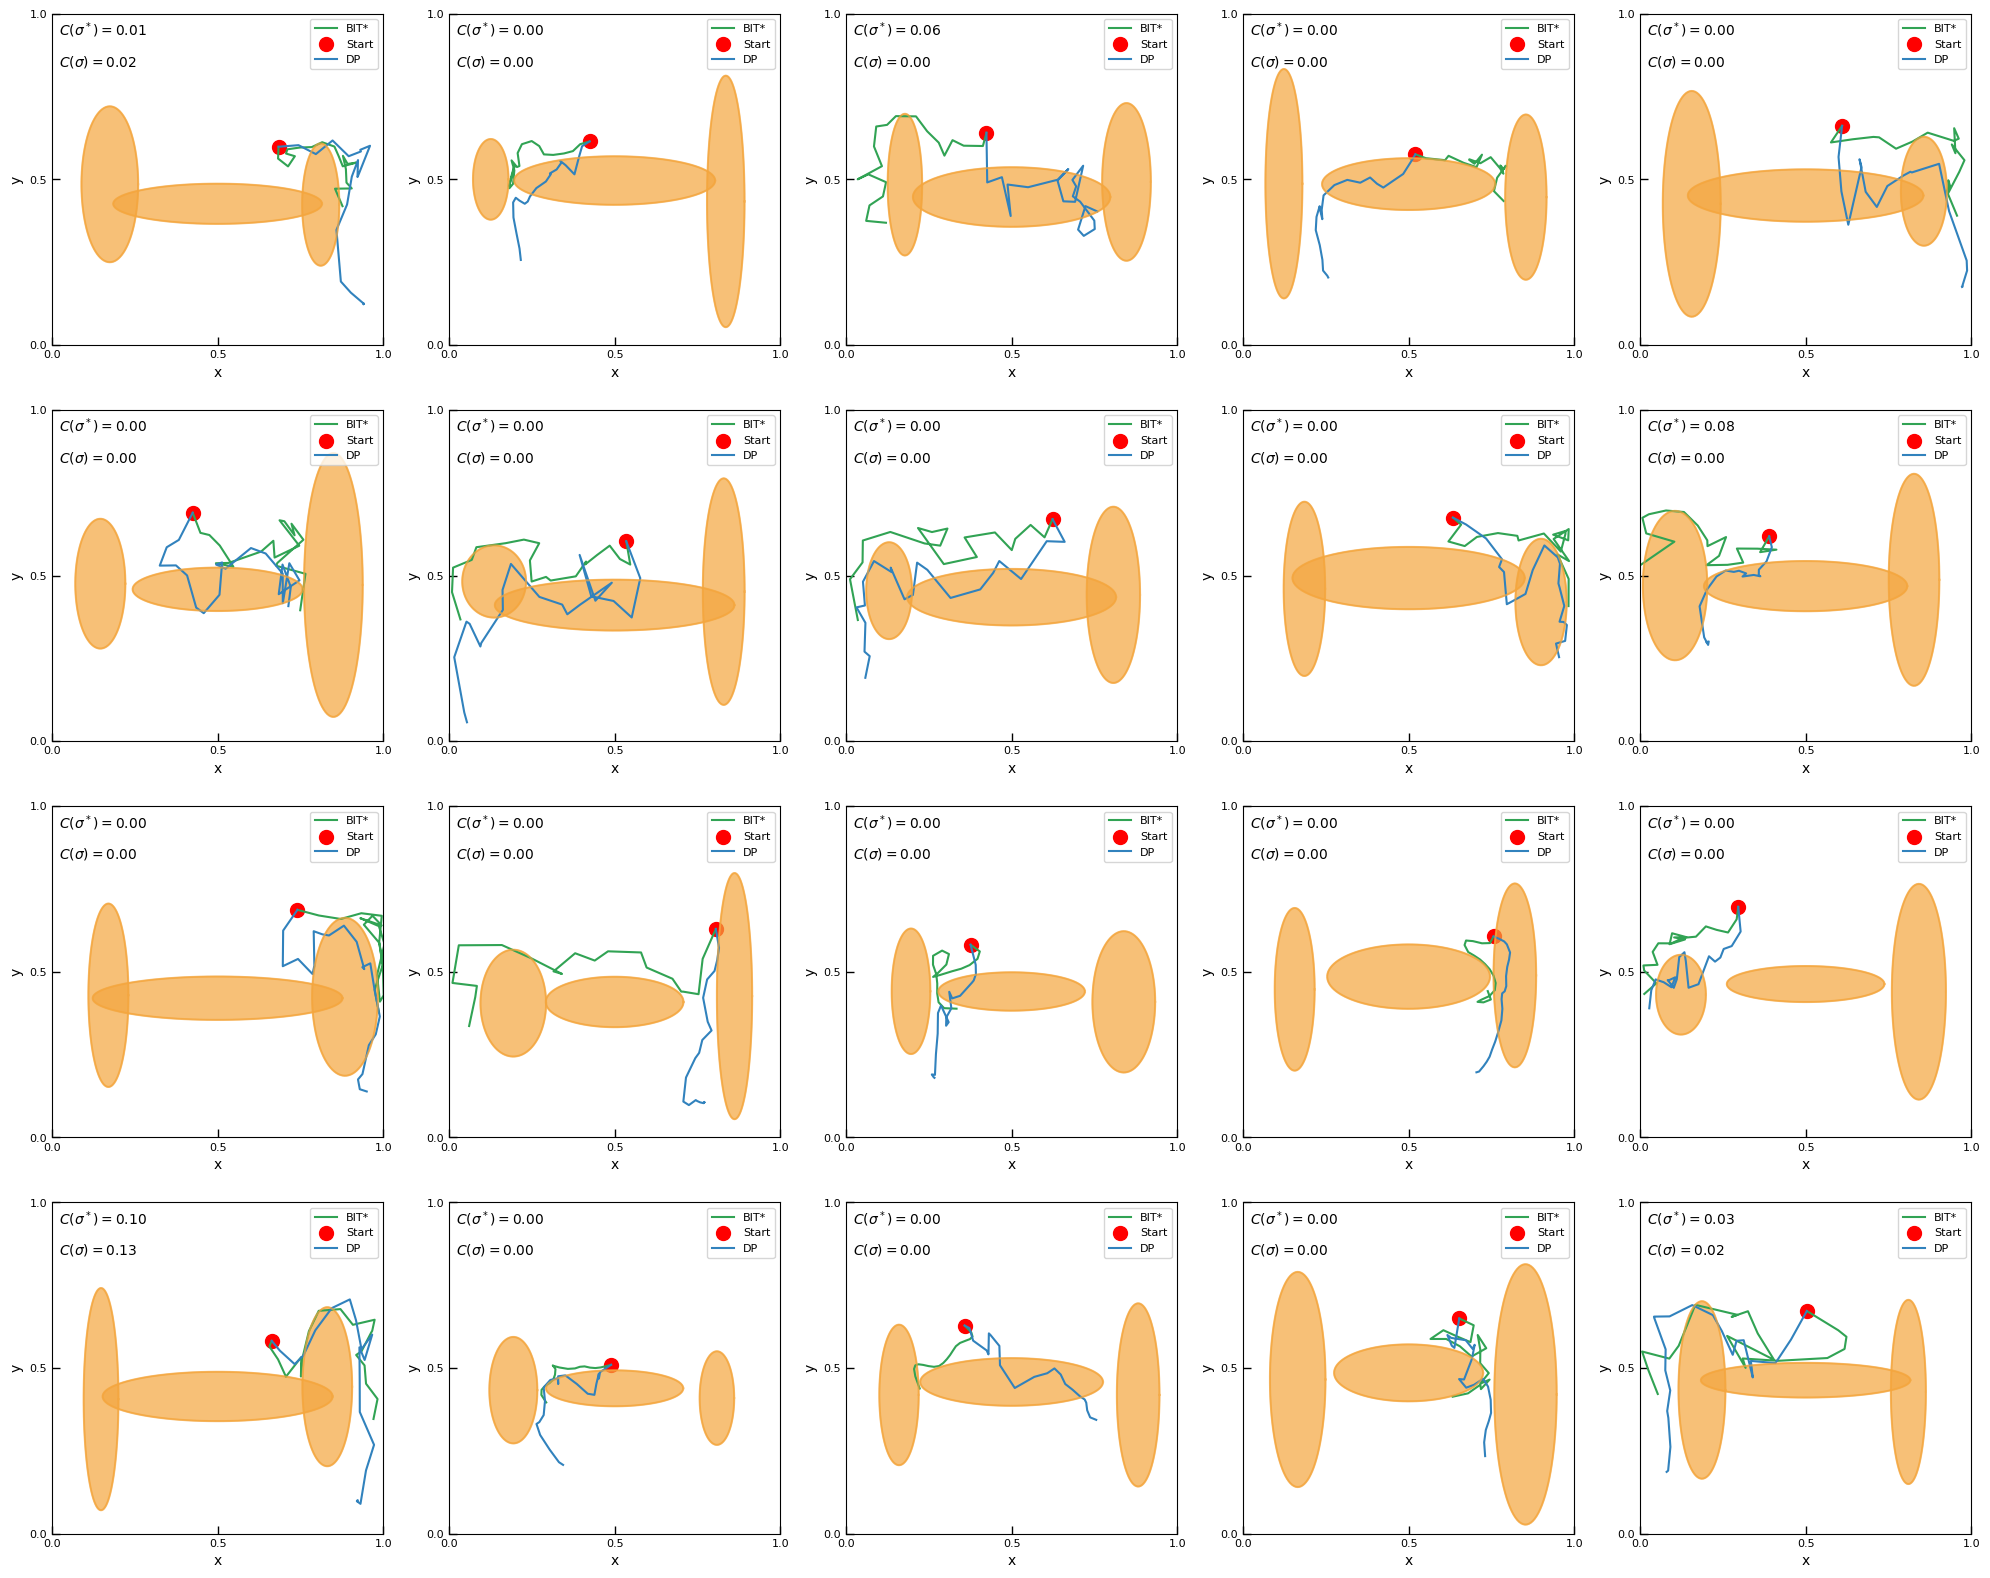

In [85]:
# Visualize the simulation result (multiple environment)
trn_data = joblib.load("dataset_escape_from_u_2d_30000_envs.joblib")
num_envs = 20
sol_path_list = []
cost_list = []
centers_list = []
rads_list = []
for env_idx in range(num_envs):
    sol_path_list.append(trn_data["paths"][-env_idx])
    cost_list.append(trn_data["costs"][-env_idx])
    centers_list.append(trn_data["ellipse_centers"][-env_idx])
    rads_list.append(trn_data["ellipse_radii"][-env_idx])

# generate escape paths for multiple environments
generated_path_list = []
generated_cost_list = []
for env_idx in range(num_envs):
    centers, rads = centers_list[env_idx], rads_list[env_idx]
    start_x = sol_path_list[env_idx][0][0]
    start_y = sol_path_list[env_idx][0][1]
    state = np.array([start_x, start_y])  # [y, y_dot, z, z_dot, phi, phi_dot]
    path = inference(state, centers, rads, max_steps=max_steps, take_only_first_action=0)
    generated_path_list.append(path)
    generated_cost_list.append(np.max(path, axis=0)[1] - start_y)

plot_multiple(sol_path_list, cost_list, centers_list, rads_list, generated_path_list, generated_cost_list)